# Visualizing training behavior

In [2]:
using JLD2, LinearAlgebra, Makie, CairoMakie

include("../../MyTwoLayerNN/MyTwoLayerNN.jl")
include("../experimentplots.jl")

using .MyTwoLayerNN

Create the NN

In [95]:
# Data parameters
d = 1
dataX = [[-1/2], [-1/6], [1/6], [1/2]]
dataY = [1/4, 1/30, 1/30, 1/4]

# NN parameters
m = 1_000
γ = 1.75    # w-lag (1.5, 0.25) lr=10, a-lag (1.5, -0.5) lr=1000
γ′ = 0.0

nn = TwoLayerNN(d, m, γ, γ′)

# Create copy of inital weights 
initialNN = copy(nn)

# Training parameters
learning_rate = 1000.0
max_steps = 100_000_000

training_data = TrainingData(dataX, dataY, learning_rate, max_steps)

TrainingData{Float64, Int64}([[-0.5], [-0.16666666666666666], [0.16666666666666666], [0.5]], [0.25, 0.03333333333333333, 0.03333333333333333, 0.25], 1000.0, 100000000)

Create callback function

In [96]:
w_norms::Vector{Float64} = []
b_norms::Vector{Float64} = []
a_norms::Vector{Float64} = []

function mycallback(nn, step, loss)
    if step % 1000 == 1
        push!(w_norms, norm(nn.w))
        push!(b_norms, norm(nn.b))
        push!(a_norms, norm(nn.a))
    end
end

mycallback (generic function with 1 method)

Train the network

In [97]:
train!(nn, training_data; callback=mycallback)

Number of steps: 129444


Visualize size of w and a parameters during training

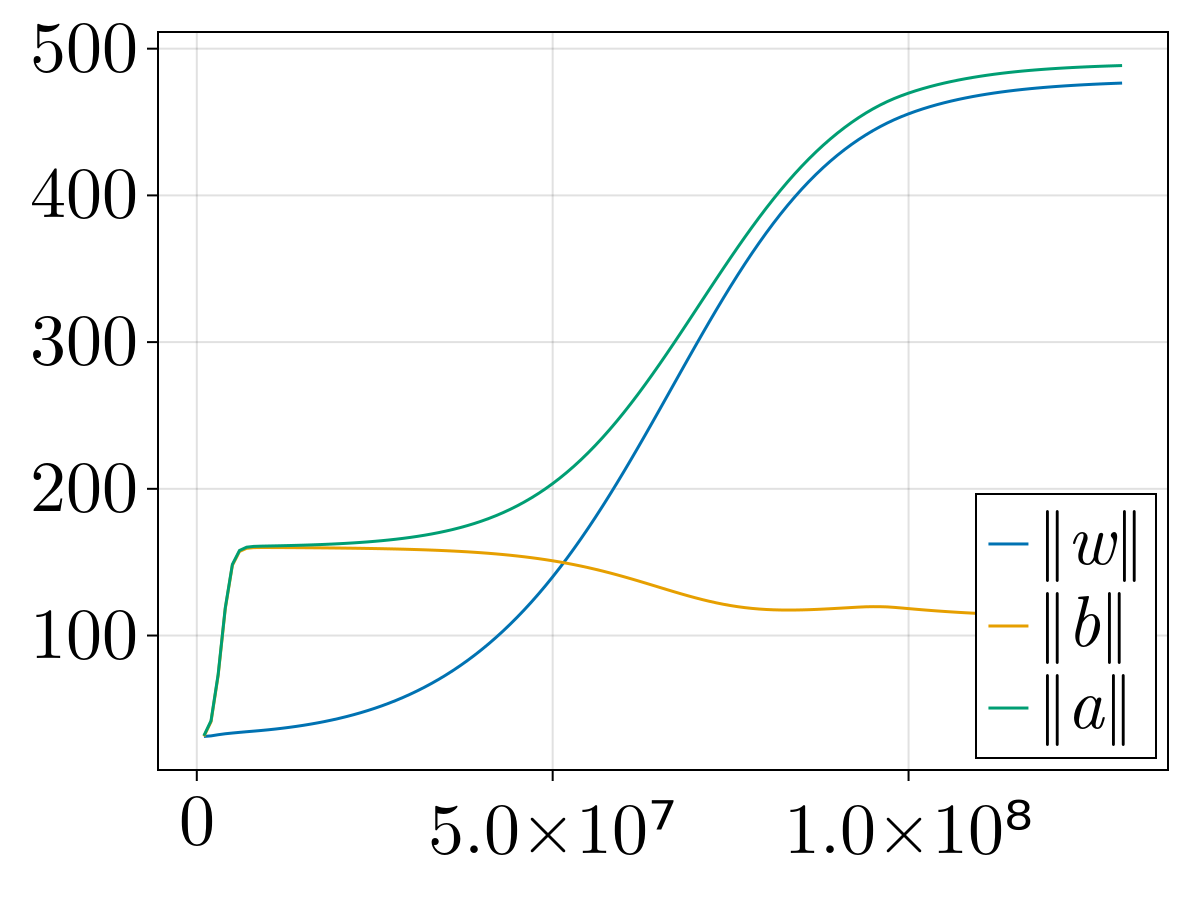

In [98]:
f = Figure()
ax = Axis(f[1, 1])

steps = 1000 * (1:length(w_norms)) * learning_rate

w_lines = lines!(ax, steps, w_norms)
b_lines = lines!(ax, steps, b_norms)
a_lines = lines!(ax, steps, a_norms)

axislegend(ax, [w_lines, b_lines, a_lines], [L"\Vert w\Vert", L"\Vert b\Vert", L"\Vert a\Vert"], position=:rb)

f

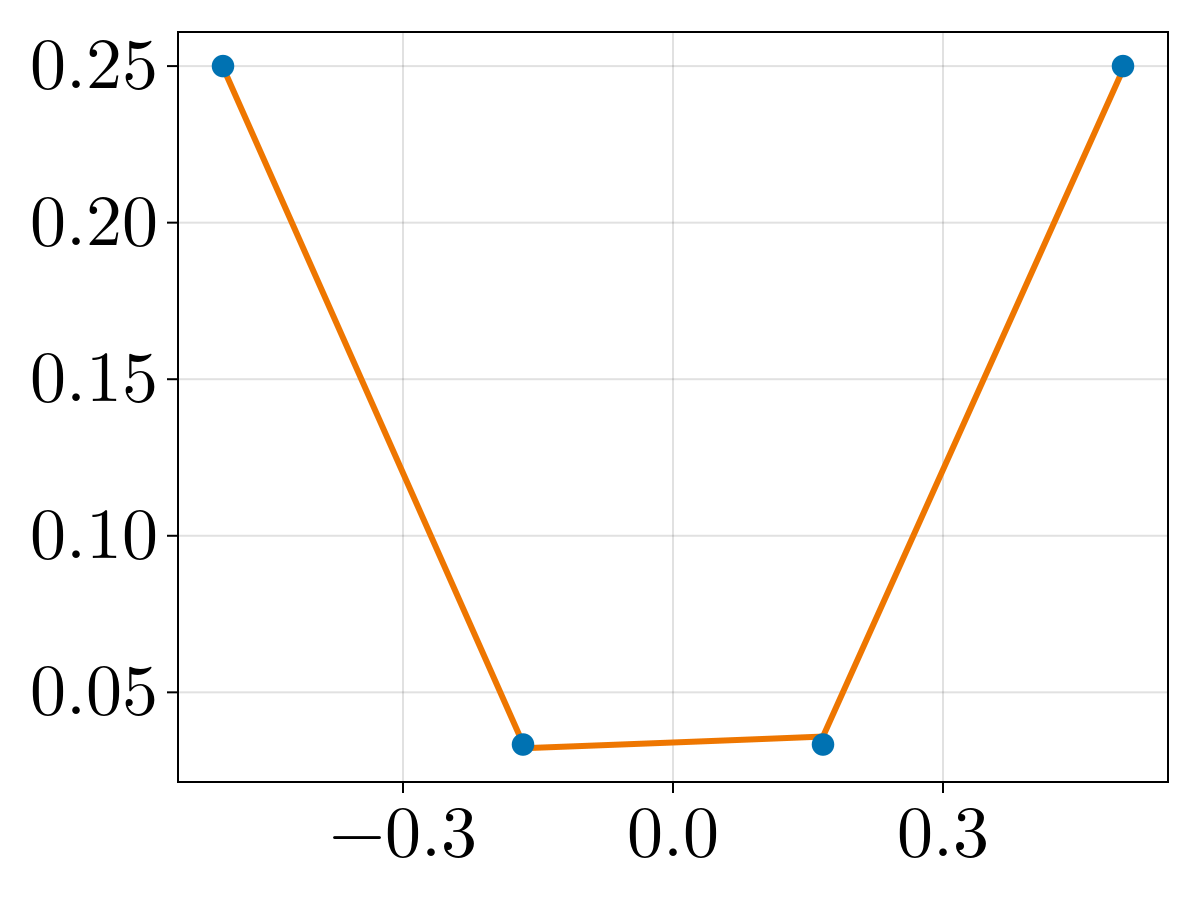

In [99]:
f = Figure()
ax = Axis(f[1, 1])

createlineplot!(ax, nn, training_data)

f

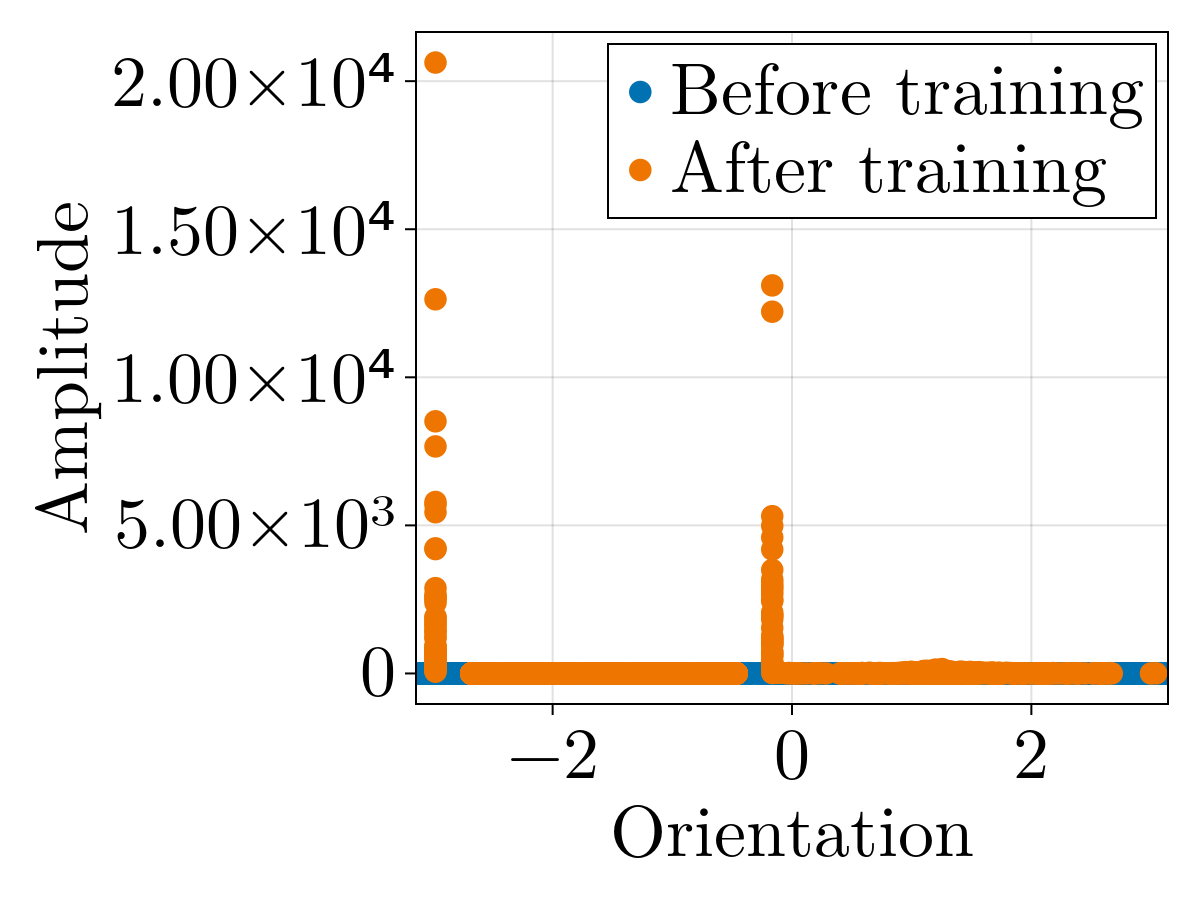

In [100]:
f = Figure()
ax = Axis(f[1, 1])

# ylims!(ax, 0, 5)

createorientiationplot!(ax, initialNN, nn)

f

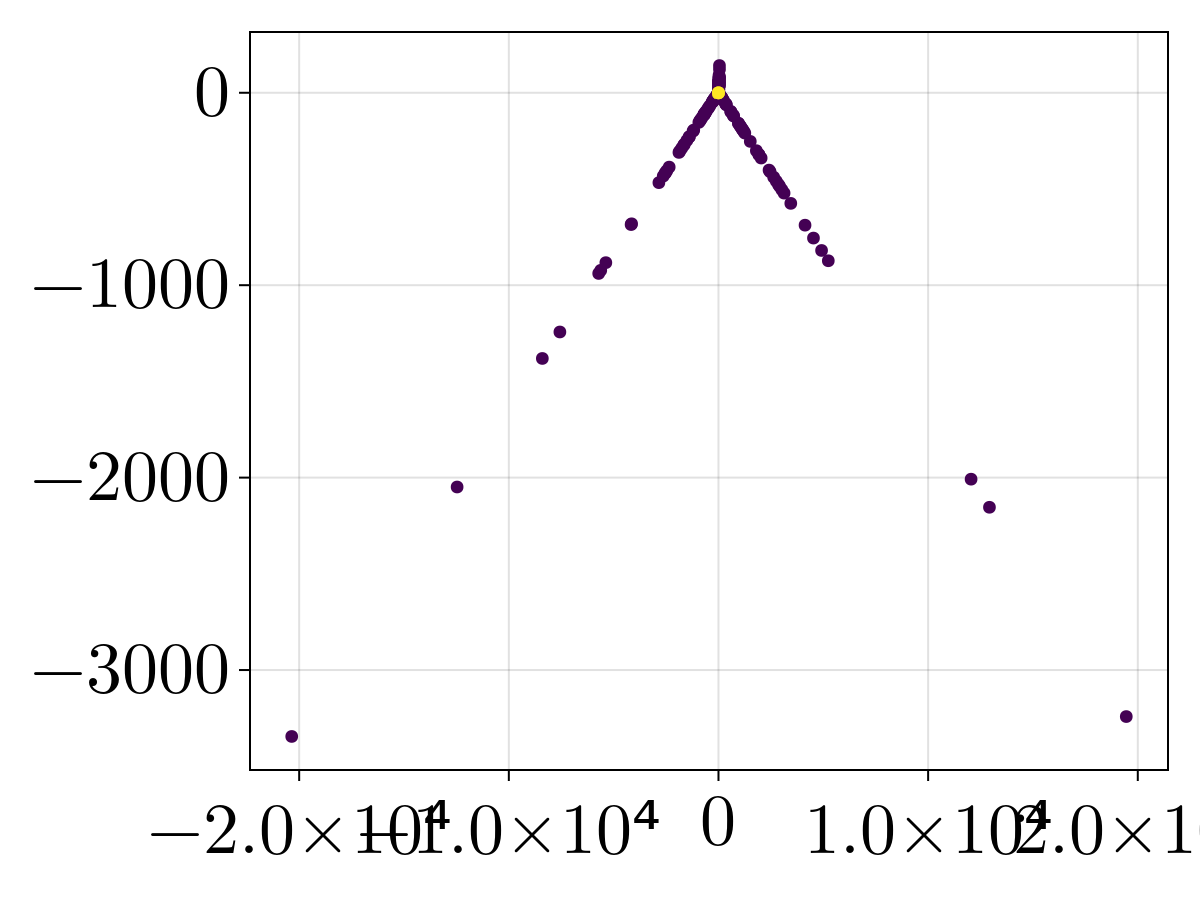

In [101]:
w_with_a = abs.(nn.a) .* vec(nn.w)
b_with_a = abs.(nn.a) .* nn.b
outputsigns = nn.a .|> signbit

f, ax, scat = scatter(w_with_a, b_with_a, color=outputsigns)

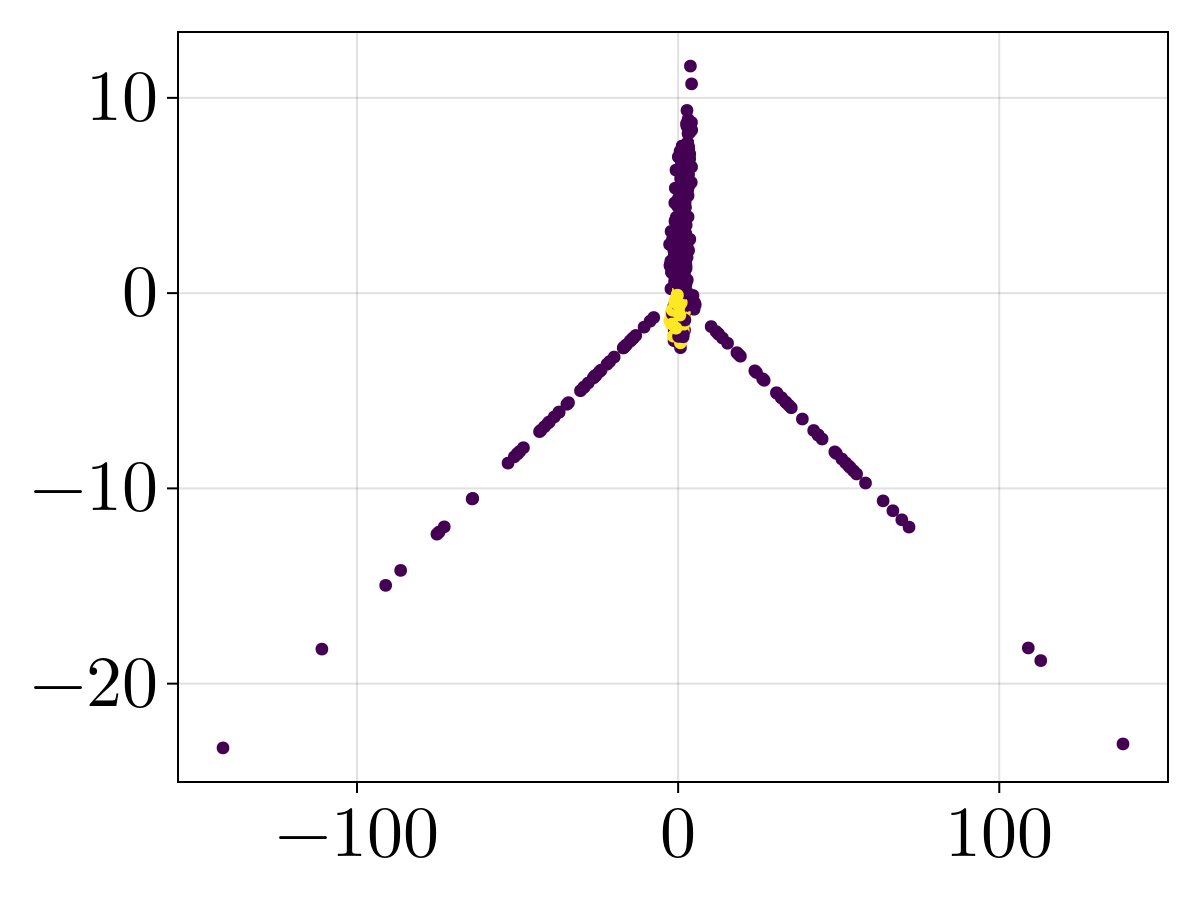

In [102]:
w_with_a = vec(nn.w)
b_with_a = nn.b
outputsigns = nn.a .|> signbit

f, ax, scat = scatter(w_with_a, b_with_a, color=outputsigns)

## Making movie

In [94]:
nn_for_vid = TwoLayerNN(d, 1000, 1.75, 0.0)
training_data_vid = TrainingData(dataX, dataY, 1000.0, 1000)

wobs = Observable(zero(abs.(nn_for_vid.a) .* vec(nn_for_vid.w)))
bobs = Observable(zero(abs.(nn_for_vid.a) .* nn_for_vid.b))
cobs = Observable(signbit.(nn_for_vid.a))
time = Observable(0.0)

fig, ax, scat = scatter(wobs, bobs, color = cobs, axis = (title = @lift("t = $(round($time, digits=1))"),))

framerate = 13
timestamps = range(0, 10, step=1/framerate)

record(fig, "parameters over time.mp4", timestamps; framerate = framerate) do t
    # Train NN 
    train!(nn_for_vid, training_data_vid)

    # Update x and y data 
    wobs[] = abs.(nn_for_vid.a) .* vec(nn_for_vid.w)
    bobs[] = abs.(nn_for_vid.a) .* nn_for_vid.b
    cobs[] = signbit.(nn_for_vid.a)
    time[] = t * framerate * max_steps * learning_rate

    autolimits!(ax)
end

Number of steps: 444
Number of steps: 1


"parameters over time.mp4"